In [1]:
'''
Tegar Imansyah
Person VGG with Keras

ref:
1. https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
2. http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
'''

# $ ls validation/neg/ | wc -l
# 6319
# $ ls validation/pos/ | wc -l
# 4639
# $ ls train/pos/ | wc -l
# 8303
# $ ls train/neg/ | wc -l
# 12810

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras.preprocessing.image as image
import numpy as np
import matplotlib.pyplot as plt

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 12810+8303
nb_validation_samples = 6319+4639
epochs = 50
batch_size = 16
input_shape = (img_width, img_height, 3) # 3 Channel, di belakang karena menggunakan tensorflow's channel_last


# path to the model weights files.
# weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'fc_model.h5'

Using TensorFlow backend.


In [2]:
# prepare data augmentation configuration
train_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 21113 images belonging to 2 classes.
Found 10958 images belonging to 2 classes.


In [3]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet',include_top= False, input_shape=(150, 150, 3))
print('Model loaded.')

Model loaded.


In [4]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
# top_model.load_weights(top_model_weights_path)


In [10]:
# Change Trainable layers until layer 15

model2 = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # Net =  VGG.input -> VGG.output -> top_model -> output
# model2.load_weights('person1491819477126.h5')

# Trainable = true
for layer in model2.layers:
    layer.trainable = True

# Trainable = false for 0 - 14
for layer in model2.layers[:15]:
    layer.trainable = False

# Show All    
i = 0
for layer in model2.layers:
    print(i,layer,layer.trainable)
    i+=1

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model2.summary()

(0, <keras.engine.topology.InputLayer object at 0x7f62e455afd0>, False)
(1, <keras.layers.convolutional.Conv2D object at 0x7f6286b8ce50>, False)
(2, <keras.layers.convolutional.Conv2D object at 0x7f62eb19aa50>, False)
(3, <keras.layers.pooling.MaxPooling2D object at 0x7f62e44ec290>, False)
(4, <keras.layers.convolutional.Conv2D object at 0x7f6286730550>, False)
(5, <keras.layers.convolutional.Conv2D object at 0x7f628673f7d0>, False)
(6, <keras.layers.pooling.MaxPooling2D object at 0x7f62867664d0>, False)
(7, <keras.layers.convolutional.Conv2D object at 0x7f62866c9a10>, False)
(8, <keras.layers.convolutional.Conv2D object at 0x7f62866ddd10>, False)
(9, <keras.layers.convolutional.Conv2D object at 0x7f62866ed350>, False)
(10, <keras.layers.pooling.MaxPooling2D object at 0x7f6286690810>, False)
(11, <keras.layers.convolutional.Conv2D object at 0x7f62866a2d90>, False)
(12, <keras.layers.convolutional.Conv2D object at 0x7f6286631c90>, False)
(13, <keras.layers.convolutional.Conv2D object at

In [2]:
# fine-tune the model
model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

NameError: name 'model' is not defined

In [8]:
import time
millis = int(round(time.time() * 1000))
weight_path = 'person' + str(millis) + '.h5'
model2.save_weights(weight_path)

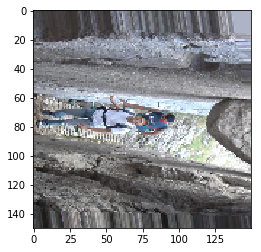

data/validation/pos/victim411_0_3707.jpeg
Predict: Victim, Actual: Victim


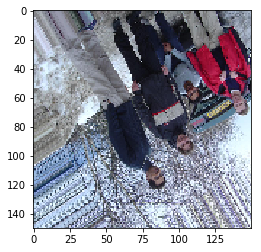

data/validation/pos/victim439_0_2402.jpeg
Predict: Victim, Actual: Victim


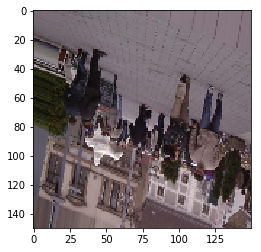

data/validation/pos/victim612_0_4069.jpeg
Predict: No Victim, Actual: Victim


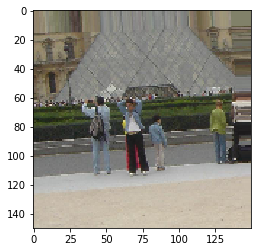

data/validation/pos/victim609_0_5201.jpeg
Predict: Victim, Actual: Victim


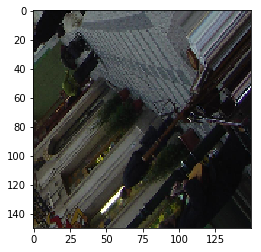

data/validation/pos/victim434_0_4797.jpeg
Predict: Victim, Actual: Victim


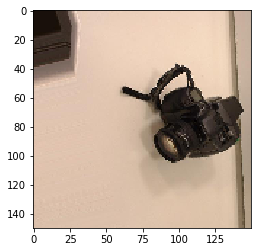

data/validation/neg/victim681_0_5220.jpeg
Predict: No Victim, Actual: No Victim


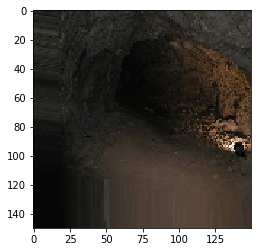

data/validation/neg/victim814_0_9338.jpeg
Predict: No Victim, Actual: No Victim


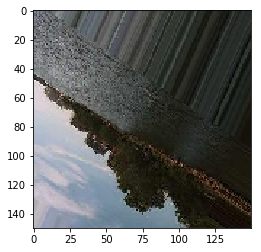

data/validation/neg/victim905_0_7828.jpeg
Predict: No Victim, Actual: No Victim


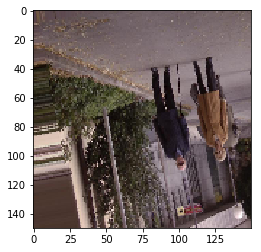

data/validation/pos/victim563_0_4096.jpeg
Predict: Victim, Actual: Victim


In [24]:
def check(probs,answer):
    if(probs[0,0] == 0):
        print('Predict: No Victim, Actual: ' + answer)
    else:
        print('Predict: Victim, Actual: ' + answer)
        
def showtest(model):  
    import os, random
    for i in range(9):
        if (np.random.randint(1,2+1) == 1):
            chosen_file = random.choice(os.listdir("data/validation/pos"))
            img_path = 'data/validation/pos/' 
            img_path+= str(chosen_file)
            answer = 'Victim'
        else:
            chosen_file = random.choice(os.listdir("data/validation/neg"))
            img_path = 'data/validation/neg/' 
            img_path+= str(chosen_file)
            answer = 'No Victim'

        
        img = image.load_img(img_path, target_size=(150,150))
        plt.imshow(img)
        plt.show()
        print(img_path)
        img = image.img_to_array(img)
        img = img.reshape((1,) + img.shape)
        probs = model.predict(img)
        check(probs, answer)

showtest(model2)

In [ ]:
# Layer untuk Raspberry PI
# Hanya dua layer, conv - conv - fc - fc 
model_raspi = Sequential()

model.add(Convolution2D(20, 5, 5, border_mode="same", input_shape=(depth, height, width)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_raspi.add(Flatten(input_shape=base_model.output_shape[1:]))
model_raspi.add(Dense(256, activation='relu'))
model_raspi.add(Dropout(0.5))
model_raspi.add(Dense(1, activation='sigmoid'))

# Main Program Sampai Disini

# acc vs val_acc?
ref: http://stackoverflow.com/questions/34702041/how-to-tell-which-keras-model-is-better

> Do I use the "acc" (from the training data?) one or the "val acc" (from the validation data?) one?

If you want to estimate the ability of your model to generalize to new data (which is probably what you want to do), then you look at the validation accuracy, because the validation split contains only data that the model never sees during the training and therefor cannot just memorize.

If your training data accuracy ("acc") keeps improving while your validation data accuracy ("val_acc") gets worse, you are likely in an overfitting situation, i.e. your model starts to basically just memorize the data.

> There are different accs and val accs for each epoch. How do I know the acc or val acc for my model as a whole? Do I average all of the epochs accs or val accs to find the acc or val acc of the model as a whole?

Each epoch is a training run over all of your data. During that run the parameters of your model are adjusted according to your loss function. The result is a set of parameters which have a certain ability to generalize to new data. That ability is reflected by the validation accuracy. So think of every epoch as its own model, which can get better or worse if it is trained for another epoch. Whether it got better or worse is judged by the change in validation accuracy (better = validation accuracy increased). Therefore pick the model of the epoch with the highest validation accuracy. Don't average the accuracies over different epochs, that wouldn't make much sense. You can use the Keras callback ModelCheckpoint to automatically save the model with the highest validation accuracy (see callbacks documentation).

The highest accuracy in model 1 is 0.7737 and the highest one in model 2 is 0.7572. Therefore you should view model 1 (at epoch 3) as better. Though it is possible that the 0.7737 was just a random outlier.

# What does "sample", "batch", "epoch" mean?

Below are some common definitions that are necessary to know and understand to correctly utilize Keras:

Sample: one element of a dataset.
Example: one image is a sample in a convolutional network
Example: one audio file is a sample for a speech recognition model
Batch: a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model.
A batch generally approximates the distribution of the input data better than a single input. The larger the batch, the better the approximation; however, it is also true that the batch will take longer to processes and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory (since larger batches will usually result in faster evaluating/prediction).
Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.
When using evaluation_data or evaluation_split with the fit method of Keras models, evaluation will be run at the end of every epoch.
Within Keras, there is the ability to add callbacks specifically designed to be run at the end of an epoch. Examples of these are learning rate changes and model checkpointing (saving).